In [46]:
%%javascript
/**********************************************************************************************
Known Mathjax Issue with Chrome - a rounding issue adds a border to the right of mathjax markup
https://github.com/mathjax/MathJax/issues/1300
A quick hack to fix this based on stackoverflow discussions: 
http://stackoverflow.com/questions/34277967/chrome-rendering-mathjax-equations-with-a-trailing-vertical-line
**********************************************************************************************/

$('.math>span').css("border-left-color","transparent")

<IPython.core.display.Javascript object>

In [42]:
%reload_ext autoreload
%autoreload 2

# Berkeley MIDS - W261 Machine Learning At Scale
__Course Lead:__ Dr James G. Shanahan (__email__ Jimi via  James.Shanahan _AT_ gmail.com)

## Assignment - HW10


---
__Name:__  James Gray   
__Class:__ MIDS W261 (Section Summer 2016 Group 1)     
__Email:__  jamesgray@iSchool.Berkeley.edu     
__Week:__   10

# Table of Contents <a name="TOC"></a> 

1.  [HW Introduction](#1)   
2.  [HW References](#2)
3.  [HW Problems](#3)   
    10.0.  [Short Answer Questions](#HW10.0)    
    10.1.  [Word Count plus sorting](#HW10.1)   
    10.2.  [MLlib-centric Kmeans](#HW10.2)    
    10.3.  [Homegrown KMeans in Spark](#HW10.3)    
    10.4.  [Making Homegrown KMeans more efficient](#HW10.4)  
    10.5.  [OPTIONAL Weighted KMeans](#HW10.5)  
    10.6.  [OPTIONAL Linear Regression](#HW10.6)  
    10.7.  [OPTIONAL Error surfaces](#HW10.7)



<a name="1">
# 1 Instructions
[Back to Table of Contents](#TOC)
* Homework submissions are due by Thursday, 07/28/2016 at 11AM (West Coast Time).


* Prepare a single Jupyter note, please include questions, and question numbers in the questions and in the responses.
Submit your homework notebook via the following form:

   + [Submission Link - Google Form](
https://docs.google.com/forms/d/1ZOr9RnIe_A06AcZDB6K1mJN4vrLeSmS2PD6Xm3eOiis/viewform?usp=send_form 
)


### Documents:
* IPython Notebook, published and viewable online.
* PDF export of IPython Notebook.
    
<a name="2">
# 2 Useful References
[Back to Table of Contents](#TOC)

* Karau, Holden, Konwinski, Andy, Wendell, Patrick, & Zaharia, Matei. (2015). Learning Spark: Lightning-fast big data analysis. Sebastopol, CA: O’Reilly Publishers.
* Hastie, Trevor, Tibshirani, Robert, & Friedman, Jerome. (2009). The elements of statistical learning: Data mining, inference, and prediction (2nd ed.). Stanford, CA: Springer Science+Business Media. (Download for free [here](http://statweb.stanford.edu/~tibs/ElemStatLearn/printings/ESLII_print10.pdf))

<a name="3">
# 3 HW Problems
[Back to Table of Contents](#TOC)

<a name="4">
# Spark Context Initialization
[Back to Table of Contents](#TOC)

In [3]:
import os
import sys 

import pyspark
#from pyspark.sql import SQLContext

# We can give a name to our app (to find it in Spark WebUI) and configure execution mode
# In this case, it is local multicore execution with "local[*]"
app_name = "hw10"
master = "local[*]"
conf = pyspark.SparkConf().setAppName(app_name).setMaster(master)
sc = pyspark.SparkContext(conf=conf)
#sqlContext = SQLContext(sc)

print sc
#print sqlContext

<a name="HW10.0"></a><h2 style="color:darkblue"> HW10.0: Short answer questions </h2>
[Back to Table of Contents](#TOC)


__What is Apache Spark and how is it different to Apache Hadoop? __

Spark is a distributed data processing framework similar to Hadoop in many ways but it leverages memory as a differentiator to achieve faster processing and lower latency. Spark performance can outpace Hadoop up to 100x faster. This memory-based model is preferred for machine learning applications given its ability to handle multiple iterations that are fairly typical. Spark does not have a storage layer but relies on the HDFS infrastructure provided by Hadoop.  Another difference is that Spark provides multiple capabilities in one framework including streaming, batch, graph, SQL and machine learning data processing.

__Fill in the blanks:
Spark API consists of interfaces to develop applications based on it in Java,Python, Scala and R languages (list languages). __

<hr>

__Using Spark, resource management can be done either in a single server instance or using a framework such as Mesos or YARN in a distributed manner. __

<hr>

__What is an RDD and show a fun example of creating one and bringing the first element back to the driver program. __

RDD stands for "Reslient Distributed Dataset" which is the Spark data structure that stores data in a key-value format. RDD's are distributed across HDFS infrastructure and can be re-created if needed.
<hr>


In [6]:
# In this example we create an RDD with 4 numbers and then use a map function to multiply each number by 2. 

rdd = sc.parallelize([1,2,3,4])
rdd.map(lambda x:  x * 2).collect()

[2, 4, 6, 8]

<a name="HW10.1"> <h2 style="color:darkgreen">HW10.1 WordCount plus sorting </h2>
[Back to Table of Contents](#TOC)

The following notebooks will be useful to jumpstart this collection of Homework exercises:


* [Example Notebook with Debugging tactics in Spark](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/jqjllp8kmf1eolk/WordCountDebugging-Example.ipynb)
* [Word Count Quiz](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/vgmpivsi4rvqz0s/WordCountQuiz.ipynb)
* [Work Count Solution](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/dxv3dmp1vluuo8i/WordCountQuiz-Solution.ipynb)

---
In Spark write the code to count how often each word appears in a text document (or set of documents). Please use this homework document (with no solutions in it) as a the example document to run an experiment.  Report the following: 
* provide a sorted list of tokens in decreasing order of frequency of occurence limited to [top 20 most frequent only] and [bottom 10 least frequent]. 


__OPTIONAL__ 
Feel free to do a secondary sort where words with the same frequncy are sorted alphanumerically increasing. Plseas refer to the [following notebook](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/uu5afr3ufpm9fy8/SecondarySort.ipynb)
 for examples of secondary sorts in Spark. Please provide the following [top 20 most frequent terms only] and [bottom 10 least frequent terms]

__NOTE__ [Please incorporate all referenced notebooks directly into this master notebook as cells for HW submission. I.e., HW submissions should comprise of just one notebook]__

In [43]:
# HW 10.1 - Count words in file/directory

logFileNAME = 'MIDS-MLS-HW-10.txt'
RDD_file = sc.textFile(logFileNAME) # read text file and create RDD

# DATA TRANSFORMATION STEPS:
# 1. split line into tokens
# 2. create word KV pairs
# 3. aggregate results by key
# 4. reverse KV pairs for sorting
# 5. sort results
# 6. un-reverse sorted KV pairs.

counts = RDD_file.flatMap(lambda line: line.split(" ")) \
             .map(lambda word: (word, 1)) \
             .reduceByKey(lambda a, b: a + b) \
             .map(lambda (a, b): (b, a)) \
             .sortByKey(0, 1) \
             .map(lambda (a, b): (b, a)) 
            
# All of the code above is lazy so this is where we will calculate and collect the results

print "Top 20 most frequent terms"
for v in counts.collect()[0:20]:
    print v

print ""
    
print "Bottom 10 least frequent terms"
for v in counts.collect()[-10:]:
    print v

Top 20 most frequent terms
(u'', 135)
(u'the', 70)
(u'and', 36)
(u'in', 25)
(u'of', 24)
(u'a', 18)
(u'for', 12)
(u'code', 12)
(u'to', 12)
(u'is', 11)
(u'model', 11)
(u'with', 10)
(u'data', 10)
(u'===', 9)
(u'as', 9)
(u'on', 9)
(u'plot', 9)
(u'this', 8)
(u'=', 8)
(u'Using', 8)

Bottom 10 least frequent terms
(u'20,', 1)
(u'descent', 1)
(u'other', 1)
(u'give', 1)
(u'center', 1)
(u'sets', 1)
(u'element', 1)
(u'graphs', 1)
(u'10.1:', 1)
(u'#10', 1)


<a name="HW10.1.1"><h2 style="color:darkgreen">HW10.1.1 </h2>
[Back to Table of Contents](#TOC)

Modify the above word count code to count words that begin with lower case letters (a-z) and report your findings. Again sort the output words in decreasing order of frequency.


In [44]:
# HW 10.1.1

logFileNAME = 'MIDS-MLS-HW-10.txt'
RDD_file = sc.textFile(logFileNAME) # read text file and create RDD

def getLowerCaseWords(line):
    # create list to hold lowercase words
    words = []
    for word in line.split(" "):
        if word.islower():
            words.append((word, 1))
    return (words)


# DATA TRANSFORMATION STEPS:
# 1. split line into tokens
# 2. create word KV pairs
# 3. aggregate results by key
# 4. reverse KV pairs for sorting
# 5. sort results
# 6. un-reverse sorted KV pairs.

counts2 = RDD_file.flatMap(lambda line: line.split(" ")) \
             .flatMap(getLowerCaseWords) \
             .reduceByKey(lambda a, b: a + b) \
             .map(lambda (a, b): (b, a)) \
             .sortByKey(0, 1) \
             .map(lambda (a, b): (b, a)) 
            
# All of the code above is lazy so this is where we will calculate and collect the results

print "Top 20 most frequent terms that are lowercase"
for v in counts2.collect()[0:20]:
    print v

print ""
    
print "Bottom 10 least frequent terms that are lowercase"
for v in counts2.collect()[-10:]:
    print v


Top 20 most frequent terms that are lowercase
(u'the', 70)
(u'and', 36)
(u'in', 25)
(u'of', 24)
(u'a', 18)
(u'for', 12)
(u'to', 12)
(u'code', 12)
(u'is', 11)
(u'model', 11)
(u'with', 10)
(u'data', 10)
(u'as', 9)
(u'plot', 9)
(u'on', 9)
(u'this', 8)
(u'your', 8)
(u'each', 7)
(u'domain', 6)
(u'from', 6)

Bottom 10 least frequent terms that are lowercase
(u'(regularization)".', 1)
(u'sure', 1)
(u'applications', 1)
(u'notebook', 1)
(u'such', 1)
(u'descent', 1)
(u'center', 1)
(u'sets', 1)
(u'element', 1)
(u'graphs', 1)


<a name="HW10.2"> <h2 style="color:darkblue"> HW10.2: MLlib-centric KMeans</h2>
[Back to Table of Contents](#TOC)

Using the following  MLlib-centric KMeans code snippet: 

<pre>
from pyspark.mllib.clustering import KMeans, KMeansModel
from numpy import array
from math import sqrt


# Load and parse the data
# NOTE  kmeans_data.txt is available here 
#          https://www.dropbox.com/s/q85t0ytb9apggnh/kmeans_data.txt?dl=0 
data = sc.textFile("kmeans_data.txt")  
parsedData = data.map(lambda line: array([float(x) for x in line.split(' ')]))

# Build the model (cluster the data)
clusters = KMeans.train(parsedData, 2, maxIterations=10,
        runs=10, initializationMode="random")

# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

WSSSE = parsedData.map(lambda point: error(point)).reduce(lambda x, y: x + y)
print("Within Set Sum of Squared Error = " + str(WSSSE))

# Save and load model
clusters.save(sc, "myModelPath")
sameModel = KMeansModel.load(sc, "myModelPath")

</pre>

__NOTE__ <p> The  __kmeans_data.txt__ is available here https://www.dropbox.com/s/q85t0ytb9apggnh/kmeans_data.txt?dl=0 

__TASKS__
* Run this code snippet and list the clusters that your find.
* compute the Within Set Sum of Squared Errors for the found clusters. Comment on your findings.

In [34]:
from pyspark.mllib.clustering import KMeans, KMeansModel
from numpy import array
from math import sqrt


# Load and parse the data
data = sc.textFile("kmeans_data.txt")  
parsedData = data.map(lambda line: array([float(x) for x in line.split(' ')]))

# Build the model (cluster the data)
clusters = KMeans.train(parsedData, 2, maxIterations=10,
        runs=10, initializationMode="random")

# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

WSSSE = parsedData.map(lambda point: error(point)).reduce(lambda x, y: x + y)
print("Within Set Sum of Squared Error = " + str(WSSSE))

# Save and load model
clusters.save(sc, "myModelPath")
sameModel = KMeansModel.load(sc, "myModelPath")


/usr/local/spark/python/pyspark/mllib/clustering.py:176: UserWarning: Support for runs is deprecated in 1.6.0. This param will have no effect in 1.7.0.
  "Support for runs is deprecated in 1.6.0. This param will have no effect in 1.7.0.")


Within Set Sum of Squared Error = 0.692820323028


In [35]:
print sameModel.clusterCenters

[DenseVector([9.1, 9.1, 9.1]), DenseVector([0.1, 0.1, 0.1])]


<a name="HW10.2"> <h2 style="color:darkblue">Analysis of Results - Within Sum of Squared Errors</h2>
[Back to Table of Contents](#TOC)

We can first look at the original data to see if there are obvious clusters

In [45]:
!cat kmeans_data.txt

0.0 0.0 0.0
0.1 0.1 0.1
0.2 0.2 0.2
9.0 9.0 9.0
9.1 9.1 9.1
9.2 9.2 9.2


By looking at the actual dataset we can see two clusters and the KMeans model has also calculate two clusters (9.1, 0.1).  These results are consistent with a relatively small WSSSE.

<a name="HW10.3"><h2 style="color:darkgreen"> HW10.3: Homegrown KMeans in Spark </h2>
[Back to Table of Contents](#TOC)

Download the following KMeans [notebook](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/3nsthvp8g2rrrdh/EM-Kmeans.ipynb).

Generate 3 clusters with 100 (one hundred) data points per cluster (using the code provided). Plot the data.
Then run MLlib's Kmean implementation on this data  and report your results as follows:

* plot the resulting clusters after 1 iteration, 10 iterations, after 20 iterations, after 100 iterations.
* in each plot please report the Within Set Sum of Squared Errors for the found clusters (as part of the title WSSSE). Comment on the progress of this measure as  the KMEans algorithms runs for more iterations. Then plot the WSSSE as a function of the iteration (1, 10, 20, 30, 40, 50, 100).



## Generate KMeans datasets

In [37]:
%matplotlib inline
import numpy as np
import pylab 
import json
size1 = size2 = size3 = 1000
samples1 = np.random.multivariate_normal([4, 0], [[1, 0],[0, 1]], size1)
data = samples1
samples2 = np.random.multivariate_normal([6, 6], [[1, 0],[0, 1]], size2)
data = np.append(data,samples2, axis=0)
samples3 = np.random.multivariate_normal([0, 4], [[1, 0],[0, 1]], size3)
data = np.append(data,samples3, axis=0)
# Randomlize data
data = data[np.random.permutation(size1+size2+size3),]
np.savetxt('data.csv',data,delimiter = ',')

/opt/conda/envs/python2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## KMeans Data Visualization

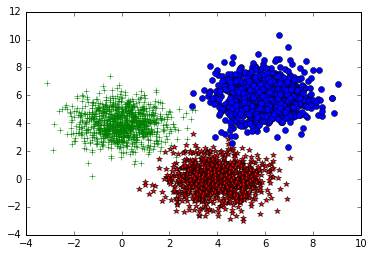

In [38]:
pylab.plot(samples1[:, 0], samples1[:, 1],'*', color = 'red')
pylab.plot(samples2[:, 0], samples2[:, 1],'o',color = 'blue')
pylab.plot(samples3[:, 0], samples3[:, 1],'+',color = 'green')
pylab.show()

In [39]:
import numpy as np

#Calculate which class each data point belongs to
def nearest_centroid(line):
    x = np.array([float(f) for f in line.split(',')])
    closest_centroid_idx = np.sum((x - centroids)**2, axis=1).argmin()
    return (closest_centroid_idx,(x,1))

#plot centroids and data points for each iteration
def plot_iteration(means):
    pylab.plot(samples1[:, 0], samples1[:, 1], '.', color = 'blue')
    pylab.plot(samples2[:, 0], samples2[:, 1], '.', color = 'blue')
    pylab.plot(samples3[:, 0], samples3[:, 1],'.', color = 'blue')
    pylab.plot(means[0][0], means[0][1],'*',markersize =10,color = 'red')
    pylab.plot(means[1][0], means[1][1],'*',markersize =10,color = 'red')
    pylab.plot(means[2][0], means[2][1],'*',markersize =10,color = 'red')
    pylab.show()

Iteration0
[[ 1.21153848  0.13114185]
 [ 3.87247391  2.66264546]
 [ 2.12810676  5.74409758]]


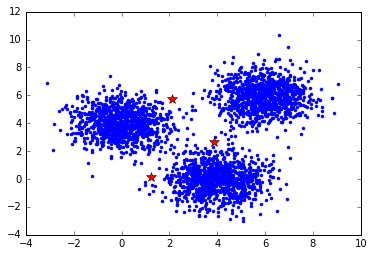

Iteration1
[[ 2.2528822   0.40468886]
 [ 5.28822796  2.71523802]
 [ 2.28706313  5.27777936]]


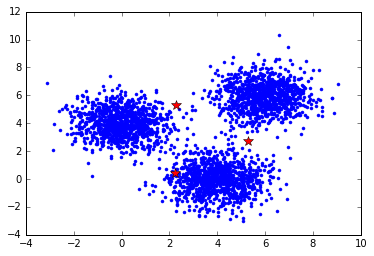

Iteration2
[[ 3.21565831  0.11604494]
 [ 6.07282164  4.49646785]
 [ 1.39872728  4.87908289]]


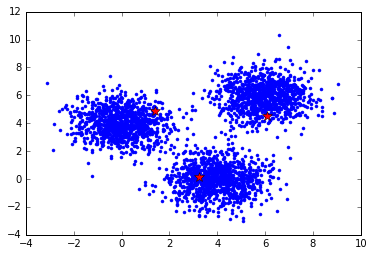

Iteration3
[[ 3.926303   -0.04396314]
 [ 5.98417113  5.90073589]
 [ 0.04052543  4.04441914]]


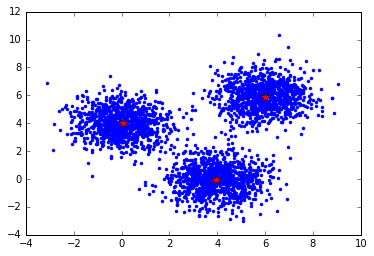

Iteration4
[[  3.97503150e+00  -3.84315641e-02]
 [  5.95863371e+00   5.94705010e+00]
 [  5.54022371e-03   3.98902336e+00]]


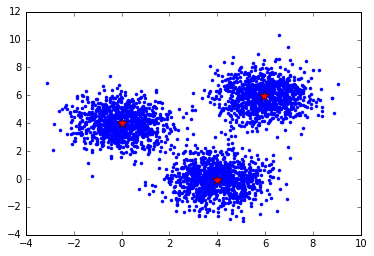

Iteration5
[[  3.97859348e+00  -3.30219834e-02]
 [  5.95903659e+00   5.95362580e+00]
 [  5.54022371e-03   3.98902336e+00]]


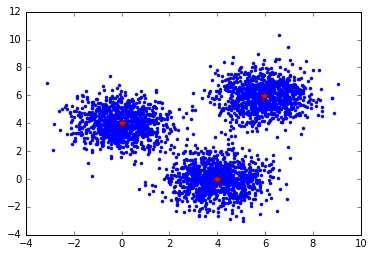

Homegrown Final Results:
[[  3.97859348e+00  -3.30219834e-02]
 [  5.95903659e+00   5.95362580e+00]
 [  5.54022371e-03   3.98902336e+00]]


In [48]:
K = 3
# Initialization: initialization of parameter is fixed to show an example
centroids = np.array([[0.0,0.0],[2.0,2.0],[0.0,7.0]])

D = sc.textFile("./data.csv").cache()
iter_num = 0
for i in range(10):  
    res = D.map(nearest_centroid).reduceByKey(lambda x,y : (x[0]+y[0],x[1]+y[1])).collect()
    #res [(0, (array([  2.66546663e+00,   3.94844436e+03]), 1001)  ), 
    #     (2, (array([ 6023.84995923,  5975.48511018]), 1000)), 
    #     (1, (array([ 3986.85984761,    15.93153464]), 999))]
    # res[1][1][1] returns 1000 here
    res = sorted(res,key = lambda x : x[0])  #sort based on clusted ID
    centroids_new = np.array([x[1][0]/x[1][1] for x in res])  #divide by cluster size
    if np.sum(np.absolute(centroids_new-centroids))<0.01:
        break
    print "Iteration" + str(iter_num)
    iter_num = iter_num + 1 
    centroids = centroids_new
    print centroids
    plot_iteration(centroids)
print "Homegrown Final Results:"
print centroids


## MLib Clustering

In [47]:
from pyspark.mllib.clustering import KMeans, KMeansModel
from numpy import array
from math import sqrt

# Load and parse the data
data = sc.textFile("data.csv")
parsedData = data.map(lambda line: array([float(x) for x in line.split(',')]))

# Build the model (cluster the data)
clusters = KMeans.train(parsedData, 3, maxIterations=20,
        runs=10, initializationMode="random")
for centroid in clusters.centers:
    print centroid

[ 5.95903659  5.9536258 ]
[ 0.00554022  3.98902336]
[ 3.97859348 -0.03302198]


## HW10.3 Discussion

The homegrown results and MLIb results produced nearly identical cluster centroids and converge very quickly. 


<a name="HW10.4"><h2 style="color:darkblue"> HW10.4: KMeans Experiments  </h2>
[Back to Table of Contents](#TOC)

Using this provided [homegrown Kmeans code](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/3nsthvp8g2rrrdh/EM-Kmeans.ipynb)   repeat the experiments in HW10.3. Explain any differences between the results in HW10.3 and HW10.4. 

In [65]:
## Code goes here

In [66]:
## Drivers & Runners

In [67]:
## Run Scripts, S3 Sync

<a name="HW10.4.1"><h2 style="color:darkblue"> HW10.4.1: Making Homegrown KMeans more efficient  </h2>
[Back to Table of Contents](#TOC)

The above provided homegrown KMeans implentation in not the most efficient. How can you make it more efficient? Make this change in the code and show it work and comment on the gains you achieve. 

### HINT: have a look at  [this linear regression notebook](    http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/atzqkc0p1eajuz6/LinearRegression-Notebook-Challenge.ipynb)

In [68]:
## Code goes here

In [69]:
## Drivers & Runners

In [70]:
## Run Scripts, S3 Sync

<a name="HW10.5"><h2 style="color:darkgreen"> HW10.5: OPTIONAL Weighted KMeans  </h2>
[Back to Table of Contents](#TOC)

Using this provided [homegrown Kmeans code](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/3nsthvp8g2rrrdh/EM-Kmeans.ipynb), modify it to do a weighted KMeans and repeat the experiements in HW10.3. Explain  any differences between the results in HW10.3 and HW10.5.

NOTE: Weight each example as follows using the inverse vector length (Euclidean norm): 

> weight(X)= 1/||X||, 

where ||X|| = SQRT(X.X)= SQRT(X1^2 + X2^2)

Here X is vector made up of two values X1 and X2.

__[Please incorporate all referenced notebooks directly into this master notebook as cells for HW submission. I.e., HW submissions should comprise of just one notebook]__

In [71]:
## Code goes here

In [72]:
## Drivers & Runners

In [73]:
## Run Scripts, S3 Sync

<a name="HW10.6"><h2 style="color:darkblue"> HW10.6 OPTIONAL Linear Regression</h2>
[Back to Table of Contents](#TOC)
<a name="HW10.6.1"><h2 style="color:darkblue"> HW10.6.1 OPTIONAL Linear Regression</h2>
[Back to Table of Contents](#TOC)

Using [this linear regression notebook](    http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/atzqkc0p1eajuz6/LinearRegression-Notebook-Challenge.ipynb):


* Generate 2 sets of data with 100 data points using the data generation code provided and plot each in separate plots. Call one the training set and the other the testing set.

* Using MLLib's LinearRegressionWithSGD train up a linear regression model with the training dataset and evaluate with the testing set. What a good number of iterations for training the linear regression model? Justify with plots (e.g., plot MSE as a function of the number of iterations) and words. 


<a name="HW10.6.2"><h2 style="color:darkblue"> HW10.6.2 OPTIONAL Linear Regression</h2>
[Back to Table of Contents](#TOC)

In the notebook provided above, in the cell labeled "Gradient descent (regularization)".

* Fill in the blanks and get this code to work for LASS0 and RIDGE linear regression.

* Using the data from HW10.6.1 tune the hyper parameters of your LASS0 and RIDGE regression. Report your findings with words and plots.

In [74]:
## Code goes here

In [75]:
## Drivers & Runners

In [76]:
## Run Scripts, S3 Sync

<a name="HW10.7"><h2 style="color:darkgreen"> HW10.7 OPTIONAL Error surfaces </h2>
[Back to Table of Contents](#TOC)

Here is a link to R code with 1 test drivers that plots the linear regression model in  model space and in the domain space:

> https://www.dropbox.com/s/3xc3kwda6d254l5/PlotModelAndDomainSpaces.R?dl=0

Here is a sample output from this script: 
      
> https://www.dropbox.com/s/my3tnhxx7fr5qs0/image%20%281%29.png?dl=0

Please use this as inspiration and code a equivalent error surface and heatmap (with isolines) in Spark and show the trajectory of learning taken during gradient descent(after each n-iterations of Gradient Descent):


Using Spark and  Python (using the above R Script as inspiration), plot the error surface for the linear regression model using a heatmap and contour plot. 
Also plot the current model in the original domain space for every 10th iteration.  Plot them side by side if possible  for each iteration: lefthand side plot is the model space(w0 and w01) and the righthand side plot is domain space (plot the corresponding model and training data in the problem domain space) with a final pair of graphs showing the entire trajectory in the model and domain space. Make sure to label your plots with iteration numbers, function, model space versus original domain space, MSE on the training data etc.

Also plot the MSE as a function of each iteration (possibly every 10th iteration). Dont forget to label both axis and the graph also. __[Please incorporate all referenced notebooks directly into this master notebook as cells for HW submission. I.e., HW submissions should comprise of just one notebook]__





In [77]:
## Code goes here

In [78]:
## Drivers & Runners

In [79]:
## Run Scripts, S3 Sync

[Back to Table of Contents](#TOC)
<center><div class='jumbotron'><h2 style='color:green'>-------  END OF HOWEWORK --------</h2></div></center>